In [1]:
from __future__ import division
from importlib import reload
from modules import * 
fig_savedir = '../data/figures/'

In [6]:
grid_params = {
    'y_height':   20,
    'x_width':    20,
    'walls':      False,
    'rho':        0,
    'maze_type':  'none',
    'port_shift': 'none'
}

agent_params = {
    'load_model':   False,
    'load_dir':     '', #'../data/outputs/gridworld/MF{}{}training.pt'.format(maze.x, maze.y),
    'action_dims':  6, #=len(maze.actionlist)
    'batch_size':   1,
    'lin_dims':     500,
    'gamma':        0.98, #discount factor
    'eta':          5e-4,
    'temperature':  1,
    'use_EC':       False,
    'cachelim':     300, #int(0.75*np.prod(maze.grid.shape)) # memory limit should be ~75% of #actions x #states
    'state_type':   'conv'
}

run_dict = {
    'NUM_EVENTS':   100,
    'NUM_TRIALS':   5000,
    'print_freq':   1/10,
    'total_loss':   [[],[]],
    'total_reward': [],
    'val_maps':     [],
    'policies':     [{},{}],
    'deltas':       [],
    'spots':        [],
    'vls':          []
}
y_height = grid_params['y_height']
x_width = grid_params['x_width']
#make environment
maze = eu.gridworld(grid_params)
maze.set_rwd([(5,5)])    #([(int(y_height/2),int(x_width/2))])

#if grid_params['maze_type'] is not 'triple_reward':
#    for i in maze.rwd_loc: 
#        maze.orig_rwd_loc.append(i)

agent_params = sg.gen_input(maze, agent_params)

env = eu.gymworld(maze)

if agent_params['load_model']: 
    MF = ac.torch.load(agent_params['load_dir']) # load previously saved model
else:
    MF = ac.AC_Net(agent_params)
opt = ac.optim.Adam(MF.parameters(), lr = agent_params['eta'])

EC = ec.ep_mem(MF,agent_params['cachelim']) 


In [7]:
# --------------------------------
# empty data frames for recording
# --------------------------------

# flags to be changed mid run
add_episodic_cache = False  ## Possibly unnecessary now 
if add_episodic_cache:
    rwd_threshold  = True
midrun_rwd_removal = False
success_benchmark  = (run_dict['NUM_EVENTS'] -((maze.y-1)+(maze.x-1)))/run_dict['NUM_EVENTS']


if midrun_rwd_removal: 
    reward_tally = {}
    for _ in maze.rwd_loc: 
        reward_tally[_] = []
    trial_rwd_switch = 0
    
use_EC = agent_params['use_EC']
EC.reset_cache()
EC.reward_unseen = True

add_mem_dict     = {} #dictionary of items which get put into memory cache
timestamp        = 0
blocktime        = time.time()
#==================================
# Run Trial
#==================================
for trial in range(run_dict['NUM_TRIALS']):
    trialstart_stamp = timestamp
    
    reward_sum   = 0
    v_last       = 0
    track_deltas = []
    track_spots  = []
    visited_locs = []
    
    env.reset() 
    state = ac.Variable(ac.torch.FloatTensor(sg.get_frame(maze)))

    MF.reinit_hid() #reinit recurrent hidden layers
    for event in range(run_dict['NUM_EVENTS']):
        # pass state through EC module
        if use_EC:
            policy_, value_, lin_act_ = MF(state,agent_params['temperature'])
            add_mem_dict['state'] = maze.cur_state
            visited_locs.append(maze.cur_state)
        else: 
            policy_, value_ = MF(state, agent_params['temperature'])[0:2]
        
        choice, policy, value = ac.select_action(MF,policy_, value_)
        if event < run_dict['NUM_EVENTS']: 
            next_state, reward, done, info = env.step(choice)

        MF.rewards.append(reward)
        delta = reward + agent_params['gamma']*value - v_last  #compute eligibility trace/rpe approximation

        
        if use_EC:
            add_mem_dict['activity']  = tuple(lin_act_.view(-1).data)
            add_mem_dict['action']    = choice
            add_mem_dict['delta']     = delta
            add_mem_dict['timestamp'] = timestamp            
            EC.add_mem(add_mem_dict, keep_hist = True)             #add event to memory cache
            if reward != 0:
                EC.reward_update(trialstart_stamp, timestamp, reward)
            #EC.reward_update(trialstart_stamp, timestamp, delta[0])
            track_deltas.append(delta[0])
            track_spots.append(maze.cur_state)
        
        if agent_params['state_type'] == 'pcs':
            state = ac.Variable(ac.torch.FloatTensor(pcs.activity(next_state)))       # update state
        elif agent_params['state_type'] == 'conv':
            state = ac.Variable(ac.torch.FloatTensor(sg.get_frame(maze)))
        reward_sum += reward
    
        v_last = value
        timestamp += 1
    
    
    if add_episodic_cache:
        if (np.array(total_reward[-50:]).mean() > success_benchmark*NUM_EVENTS):
            if rwd_threshold:
                print(" \t Started Memory at Trial ", trial)
                if midrun_rwd_removal:
                    maxsums = {}
                    for item in reward_tally.items():
                        maxsums[item[0]] = sum(item[1])
                    most_rewarded_location = max(maxsums.iteritems(), key=operator.itemgetter(1))[0] 
                    maze.rwd_loc.remove(most_rewarded_location)
                    trial_rwd_switch = trial
                    print("removed reward at ", most_rewarded_location)

                rwd_threshold = False
                use_EC = True
    
    if midrun_rwd_removal:
        if (trial_rwd_switch!=0) and (trial == trial_rwd_switch + 1000):
            maze.rwd_loc.append(most_rewarded_location)

    p_loss, v_loss = ac.finish_trial(MF,agent_params['gamma'],opt)
    
    run_dict['total_loss'][0].append(p_loss.data[0])
    run_dict['total_loss'][1].append(v_loss.data[0])
    run_dict['total_reward'].append(reward_sum)
    
    if agent_params['state_type'] == 'pcs':
        value_map = ac.generate_values(maze,MF,pcs=pcs)
    else:
        value_map = ac.generate_values(maze,MF)
    run_dict['val_maps'].append(value_map.copy())
    
    if midrun_rwd_removal:
        for item in maze.reward_tally.items():
            reward_tally[item[0]].append(item[1])
            
    run_dict['deltas'].append(track_deltas)
    run_dict['spots'].append(track_spots)
    run_dict['vls'].append(visited_locs)
    if trial ==0 or trial%100==0 or trial == run_dict['NUM_TRIALS']-1:
        #EC_policies, MF_policies = ac.generate_values(maze, MF,EC=EC)
        #run_dict['policies'][0]['{}'.format(trial)] = EC_policies
        #run_dict['policies'][1]['{}'.format(trial)] = MF_policies
        #print("[{0}]  Trial {1} total reward = {2} (Avg {3:.3f})".format(time.strftime("%H:%M:%S", time.localtime()), trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime))
        print("[{0}]  Trial {1} TotRew = {2} ({3:.3f}s)".format(time.strftime("%H:%M:%S", time.localtime()), trial+1, reward_sum,time.time()-blocktime))
        blocktime = time.time()

/home/annik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:103: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/annik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[22:14:20]  Trial 1 TotRew = 0 (0.275s)


KeyboardInterrupt: 

In [28]:
# --------------------------------
# empty data frames for recording
# --------------------------------

# flags to be changed mid run
add_episodic_cache = False  ## Possibly unnecessary now 
if add_episodic_cache:
    rwd_threshold  = True
midrun_rwd_removal = False
success_benchmark  = (run_dict['NUM_EVENTS'] -((maze.y-1)+(maze.x-1)))/run_dict['NUM_EVENTS']


if midrun_rwd_removal: 
    reward_tally = {}
    for _ in maze.rwd_loc: 
        reward_tally[_] = []
    trial_rwd_switch = 0
    
use_EC = agent_params['use_EC']
EC.reset_cache()
EC.reward_unseen = True

add_mem_dict     = {} #dictionary of items which get put into memory cache
timestamp        = 0
blocktime        = time.time()
#==================================
# Run Trial
#==================================
for trial in range(run_dict['NUM_TRIALS']):
    trialstart_stamp = timestamp
    
    reward_sum   = 0
    v_last       = 0
    track_deltas = []
    track_spots  = []
    visited_locs = []
    
    env.reset() 
    state = ac.Variable(ac.torch.FloatTensor(sg.get_frame(maze)))

    MF.reinit_hid() #reinit recurrent hidden layers
    for event in range(run_dict['NUM_EVENTS']):
        # pass state through EC module
        policy_, value_ = MF(state, agent_params['temperature'])[0:2]
        
        choice, policy, value = ac.select_action(MF,policy_, value_)
        if event < run_dict['NUM_EVENTS']: 
            next_state, reward, done, info = env.step(choice)

        MF.rewards.append(reward)
        delta = reward + agent_params['gamma']*value - v_last  #compute eligibility trace/rpe approximation

        
        state = ac.Variable(ac.torch.FloatTensor(sg.get_frame(maze)))
        reward_sum += reward
    
        v_last = value
        timestamp += 1

    p_loss, v_loss = ac.finish_trial(MF,agent_params['gamma'],opt)
    
    run_dict['total_loss'][0].append(p_loss.data[0])
    run_dict['total_loss'][1].append(v_loss.data[0])
    run_dict['total_reward'].append(reward_sum)
    
    value_map = ac.generate_values(maze,MF)
    run_dict['val_maps'].append(value_map.copy())
    
    if trial ==0 or trial%100==0 or trial == run_dict['NUM_TRIALS']-1:
        #EC_policies, MF_policies = ac.generate_values(maze, MF,EC=EC)
        #run_dict['policies'][0]['{}'.format(trial)] = EC_policies
        #run_dict['policies'][1]['{}'.format(trial)] = MF_policies
        #print("[{0}]  Trial {1} total reward = {2} (Avg {3:.3f})".format(time.strftime("%H:%M:%S", time.localtime()), trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime))
        print("[{0}]  Trial {1} TotRew = {2} ({3:.3f}s)".format(time.strftime("%H:%M:%S", time.localtime()), trial+1, reward_sum,time.time()-blocktime))
        blocktime = time.time()

/home/annik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/annik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[18:00:00]  Trial 1 TotRew = 0 (0.280s)
[18:00:32]  Trial 101 TotRew = 1 (31.352s)
[18:01:06]  Trial 201 TotRew = 0 (34.087s)
[18:01:39]  Trial 301 TotRew = 0 (32.990s)
[18:02:15]  Trial 401 TotRew = 0 (36.144s)
[18:02:50]  Trial 501 TotRew = 0 (35.432s)
[18:03:28]  Trial 601 TotRew = 0 (37.342s)
[18:04:08]  Trial 701 TotRew = 0 (40.604s)
[18:04:50]  Trial 801 TotRew = 0 (41.871s)
[18:05:31]  Trial 901 TotRew = 0 (41.069s)
[18:06:12]  Trial 1001 TotRew = 0 (40.192s)
[18:06:51]  Trial 1101 TotRew = 0 (39.622s)
[18:07:29]  Trial 1201 TotRew = 0 (38.295s)
[18:08:06]  Trial 1301 TotRew = 0 (36.681s)
[18:08:45]  Trial 1401 TotRew = 86 (38.479s)
[18:09:26]  Trial 1501 TotRew = 88 (41.651s)
[18:10:09]  Trial 1601 TotRew = 88 (42.369s)
[18:10:48]  Trial 1701 TotRew = 81 (39.207s)
[18:11:25]  Trial 1801 TotRew = 72 (36.708s)
[18:12:12]  Trial 1901 TotRew = 91 (47.493s)
[18:13:09]  Trial 2001 TotRew = 81 (57.041s)
[18:13:52]  Trial 2101 TotRew = 85 (42.482s)
[18:14:32]  Trial 2201 TotRew = 85 (4

NameError: name 'NUM_EVENTS' is not defined

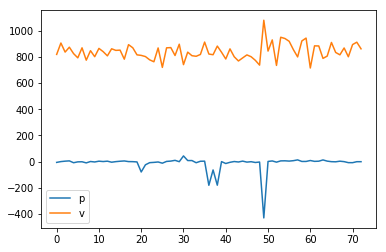

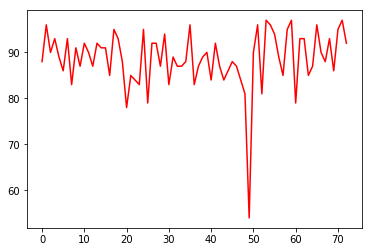

In [8]:
plt.figure(0)
total_loss = run_dict['total_loss']
total_reward = run_dict['total_reward']
plt.plot(total_loss[0], label='p')
plt.plot(total_loss[1], label='v')
plt.legend(loc=0)

plt.figure(1)
plt.plot(total_reward, label='r', color='r', marker='')
plt.axhline(NUM_EVENTS-(grid_params['y_height']-maze.rwd_loc[0][0] + grid_params['x_width']-maze.rwd_loc[0][1]), color = 'gray', linestyle='--')
#plt.figure(2)
#delta_of_interest = deltas[-1]
#plt.plot(deltas[-1])
#plt.annotate('{}'.format(spots[-1][np.argmax(delta_of_interest)]), xy=(np.argmax(delta_of_interest), max(delta_of_interest)) )
#print(maze.rwd_loc[0])

#if maze_type == 'triple_reward':
#    plt.figure(2)
#    plt.plot(reward_tally[reward_tally.keys()[0]], label='{}'.format(reward_tally.keys()[0]))
#    plt.plot(reward_tally[reward_tally.keys()[1]], label='{}'.format(reward_tally.keys()[1]))
#    plt.plot(reward_tally[reward_tally.keys()[2]], label='{}'.format(reward_tally.keys()[2]))
#    plt.legend(loc=0)

<Figure size 432x288 with 0 Axes>

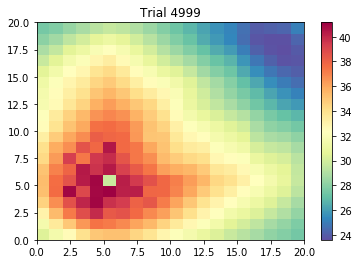

In [31]:
val_maps = run_dict['val_maps']
#trained_val_map
gp.print_value_maps(maze,
                    val_maps,
                    maps=-1,#list(np.arange(850, 1050)), 
                    val_range=(-1,50),
                    save_dir=fig_savedir,
                    title='Value Map') ### see individual map with kwarg maps=X

<Figure size 432x288 with 0 Axes>

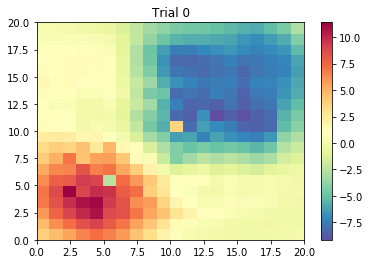

In [36]:
a1 = val_maps[-1] - trained_val_map[0]
gp.print_value_maps(maze, [a1], maps=0, val_range=(-1,50), save_dir = fig_savedir, title="ValueMaps")

In [8]:
reload(eu)
EC_policy = np.zeros((maze.y, maze.x), dtype=[('N', 'f8'), ('E', 'f8'),('W', 'f8'), ('S', 'f8'),('stay', 'f8'), ('poke', 'f8')])
ex = EC_policy[0][0]
for i in EC.cache_list.keys():
    loc = EC.cache_list[i][2]
    pol = EC.cache_list[i][0]
    t = EC.cache_list[i][1]
    if max(tuple(eu.softmax(pol))) > max(EC_policy[loc[1]][loc[0]]):
        EC_policy[loc[1]][loc[0]] = tuple(eu.softmax(pol))
    #    previous_pol = np.asarray(EC_policy[loc[1]][loc[0]])
    #    print( previous_pol,np.asarray(eu.softmax(pol) ))
    #    new_pol = tuple(eu.softmax(np.add(np.asarray(eu.softmax(pol)),previous_pol)))
    #    EC_policy[loc[1]][loc[0]] = tuple(eu.softmax(pol))



In [ ]:
reload(eu)
test1 = [int(po) for po in policies[1].keys()]

epoch = max(test1)
print(epoch)
eu.make_dual_policy_plots(maze, EC_policy, policies[1][str(epoch)], savedir='PolMaps.svg')#EC_policies, MF_policies)

In [ ]:
fig = plt.figure()

cmap      = plt.cm.Spectral_r
cNorm     = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm = cNorm, cmap=cmap)


ax1 = fig.add_axes([0.04, 0, 0.85, 0.85]) # [left, bottom, width, height]
axc = fig.add_axes([0.89, 0.125, 0.05, 0.6])
cb1 = colorbar.ColorbarBase(axc, cmap=cmap, norm=cNorm)

ax1.imshow(maze.grid, vmin=0, vmax=1, cmap='bone', interpolation='none')
ax1.add_patch(patches.Circle((10,10), 0.35, fc='k', ec='w'))
#ax1.add_patch(patches.Circle(maze.start_loc, 0.5, fc='b', ec='w'))
ax1.add_patch(patches.Circle(maze.rwd_loc[0], 0.35, fc='w'))

codes = [Path.MOVETO]
for i in range(len(vls[0])-1):
    codes.append(Path.LINETO)

for i in range(len(vls)):
    path = Path(vls[i], codes)
    patch = patches.PathPatch(path, edgecolor='gray', facecolor='none', linestyle=':', lw=2)
    ax1.add_patch(patch)

chance_threshold = np.round(1/len(maze.actionlist),6)
use_recency      = True

for i in EC.cache_list.keys():
    loc = EC.cache_list[i][2]
    pol = eu.softmax(EC.cache_list[i][0])
    t   = EC.cache_list[i][1]
    
    if use_recency: 
        if t<101:
            recency = 1
        else:
            recency = 0
        #recency = abs(1-t/(trial*NUM_EVENTS))
        #if recency > 1: 
        #    recency = 1
    else:
        recency = 1 
    
    action = np.argmax(pol)
    prob   = max(pol)


    dx1,dy1,head_w,head_l = eu.make_arrows(action, prob)
    
    if prob > chance_threshold:
        if (dx1, dy1) == (0,0):
            pass
        else:
            colorVal1 = scalarMap.to_rgba(prob)
            ax1.arrow(loc[0], loc[1], 
                      dx1, dy1, 
                      head_width  = 0.3, 
                      head_length = 0.2, 
                      color       = colorVal1, 
                      alpha       = recency)
    else:
        pass

plt.savefig('ECpol_T_inf_newrwd.svg', format='svg')
plt.show()

In [ ]:
print(visited_locs[0])

In [ ]:
grid_dict = {}
for prop, propval in vars(maze).iteritems():
    grid_dict[prop]= propval
store_data= {}
store_data['total_reward'] = total_reward
store_data['total_loss'] = total_loss
store_data['val_maps'] = val_maps
store_data['EC'] = EC
store_data['MF'] = MF
if use_EC:
    store_data['policies'] = policies
store_data['params'] = {'grid':grid_dict,
                       'state_type':state_type,
                       'discount_factor': discount_factor,
                       'eta':eta, 
                       'runtime':[NUM_EVENTS, NUM_TRIALS]}
store_data['maze'] = maze
datestamp = time.strftime("%y%m%d_%H%M", time.localtime())
np.save('../data/outputs/gridworld/pydicts/{}.npy'.format(datestamp), store_data)

In [29]:
## saving model
ac.torch.save(MF,'../data/outputs/gridworld/MF2020training.pt') 

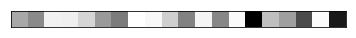

In [61]:
a = np.random.randn(1,20)
plt.imshow(a,cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.savefig('activities.svg', format='svg')

In [ ]:
'''
state_type = agent_params['state_type']
if state_type == 'conv':
    num_channels = 3
    if maze.bound:
        input_dims = (y_height+2, x_width+2, num_channels)
    else:
        input_dims = (y_height, x_width, num_channels)
    hid_types = ['conv', 'pool', 'linear']
    conv_dims = ac.conv_output(input_dims)
    pool_dims = ac.conv_output(conv_dims)
    hid_dims = [conv_dims, pool_dims, 500]

elif state_type == 'pcs':
    input_dims = 1000
    hid_types = ['linear']
    hid_dims = [500]
    
action_dims = len(maze.actionlist)
batch_size = 1

NUM_EVENTS = 100
NUM_TRIALS = 5000

discount_factor = 0.98
'''